### Wordle solving

FilterBox is great at find-by-constraint, which is the key component of a Wordle solver.

Wordle is a popular word game, playable [here](https://www.nytimes.com/games/wordle/index.html).

This notebook shows how to efficiently create many filter functions - one for each letter and each position - without having to write each one by hand.

Skip to the end for performance: FilterBox outperforms a list comprehension by about 50X here.

In [1]:
import os
import string
import time

from collections import namedtuple
from functools import partial
from pathlib import Path
from typing import Dict

from filterbox import FrozenFilterBox

#### Load data

`wordle_words.csv` is a 2-column CSV containing all 5-letter words and their frequency in English.

In [2]:
cwd = Path(os.getcwd())
words_file = cwd / 'data' / 'wordle_words.csv'
WordFreq = namedtuple('WordFreq', ('word', 'freq'))

def load_data() -> Dict[str, int]:
    word_freqs = []
    with open(words_file) as fh:
        for i, line in enumerate(fh.readlines()):
            if i == 0:  # header
                continue
            word, freq = line.strip().split(',')
            word_freqs.append(WordFreq(word, int(freq)))
    return word_freqs


# Show the first 10 words
word_freqs = load_data()
for i in range(10):
    print(word_freqs[i])

WordFreq(word='ABOUT', freq=1226734006)
WordFreq(word='OTHER', freq=978481319)
WordFreq(word='WHICH', freq=810514085)
WordFreq(word='THEIR', freq=782849411)
WordFreq(word='THERE', freq=701170205)
WordFreq(word='FIRST', freq=578161543)
WordFreq(word='WOULD', freq=572644147)
WordFreq(word='THESE', freq=541003982)
WordFreq(word='CLICK', freq=536746424)
WordFreq(word='PRICE', freq=501651226)


#### Create functions

We want to filter words that have, or don't have:
 - A specific character in a specific position
 - A total count of a specific character, anywhere in the word
 
So we'll make two sets of functions using `functools.partial`. 
Consult the [functools.partial](https://docs.python.org/3/library/functools.html#functools.partial)  documentation if needed.

In [3]:
# Generate 5 functions, one for each position, to fetch the letter at that position in the word.
def char_at(pos, wf):
    return wf.word[pos]

def make_char_at_function(pos):
    p = partial(char_at, pos)
    p.__name__ = f'at_{pos}'
    return p

char_at = {pos: make_char_at_function(pos) for pos in range(5)}

In [4]:
# Generate 26 functions that count the occurrences of the specific letter.

def char_count(c, wf):
    return wf.word.count(c)

def make_char_count_function(letter):
    p = partial(char_count, letter)
    p.__name__ = f'count_{letter}'
    return p

char_count = {letter: make_char_count_function(letter) for letter in string.ascii_uppercase}

#### Build FilterBox

Now that we have the objects and the functions we'll use as attributes, build the FilterBox.

We'll use a FrozenFilterBox here, as it's faster and we don't expect the objects to change.

In [5]:
t0 = time.time()
f = FrozenFilterBox(word_freqs, on=list(char_at.values()) + list(char_count.values()))
print('Build time:', round(time.time()-t0, 3), 'seconds.')

Build time: 0.412 seconds.


In [6]:
def top_ten(word_freqs):
    """Prints the top ten most frequent words in the FilterBox result."""
    top_ten = list(sorted(word_freqs, key = lambda w: w.freq, reverse=True))[:10]
    print(f'{len(word_freqs)} words remain. \nHere are the top ten most frequent:')
    for wf in top_ten:
        print(wf.word)

#### Let's solve! 

We don't know anything yet, so we'll just guess a common word.



In [7]:
word_freqs = f.find()  # Query with no arguments to get all
top_ten(word_freqs)    # print the top ten

12972 words remain. 
Here are the top ten most frequent:
ABOUT
OTHER
WHICH
THEIR
THERE
FIRST
WOULD
THESE
CLICK
PRICE


#### Guess 'ABOUT'

Seems reasonable.

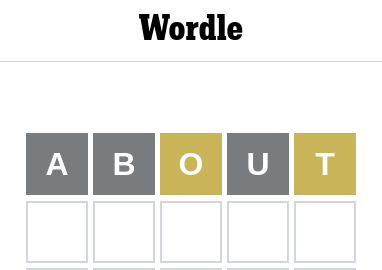

We now know some matching characteristics:
 - There are 0 'A's in the word
 - There are 0 'B's in the word
 - There are 0 'U's in the word

And some exclusion characteristics:
 - Position 2 is not 'O' -- otherwise it would be green
 - Position 4 is not 'T' -- otherwise it would be green
 - There are more than 0 'O's in the word.
 - There are more than 0 'T's in the word.

In [8]:
word_freqs = f.find(
    match={
        char_count['A']: 0,
        char_count['B']: 0,
        char_count['U']: 0,
    },
    exclude={
        char_at[2]: 'O',
        char_at[4]: 'T',
        char_count['O']: 0,
        char_count['T']: 0,
    }
) 
top_ten(word_freqs)

306 words remain. 
Here are the top ten most frequent:
OTHER
HOTEL
NORTH
POSTS
TOPIC
MONTH
COSTS
OFTEN
NOTES
WORTH


In [9]:
x = f.find(match={char_count['A']: 0,}) 
print(len(x))

7642


#### Guess 'OTHER'

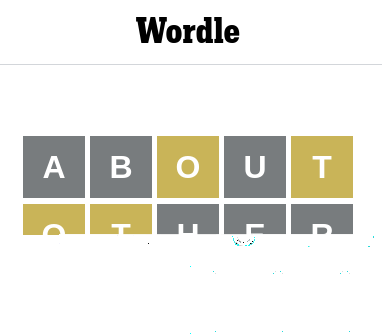

We've got some new information on what to include:
 - There are 0 'H's
 - There are 0 'E's
 - There are 0 'R's

And what to exclude:
 - There is no 'O' at position 0
 - There is no 'T' at position 1

In [10]:
word_freqs = f.find(
    match={
        char_count['A']: 0,
        char_count['B']: 0,
        char_count['E']: 0,
        char_count['H']: 0,
        char_count['R']: 0,
        char_count['U']: 0,
    },
    exclude={
        char_at[0]: 'O',
        char_at[1]: 'T',
        char_at[2]: 'O',
        char_at[4]: 'T',
        char_count['O']: 0,
        char_count['T']: 0,
    }
) 
top_ten(word_freqs)

99 words remain. 
Here are the top ten most frequent:
POSTS
TOPIC
COSTS
TOWNS
FONTS
TOMMY
TOXIC
LOTTO
MOTIF
MONTY


#### Guess 'POSTS'

Getting somewhere.

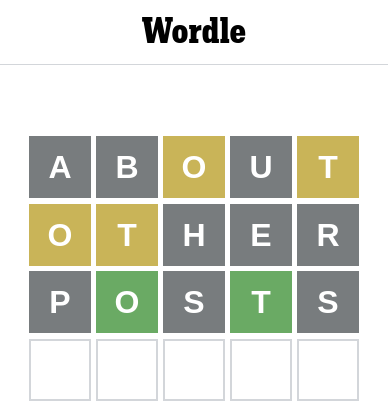

Now we know:
 - 'O' is at position 1
 - 'T' is at position 3
 - There are 0 'P's
 - There are 0 'S's

In [11]:
word_freqs = f.find(
    match={
        char_count['A']: 0,
        char_count['B']: 0,
        char_count['E']: 0,
        char_count['H']: 0,
        char_count['P']: 0,
        char_count['R']: 0,
        char_count['S']: 0,
        char_count['U']: 0,
        char_at[1]: 'O',
        char_at[3]: 'T',
    },
    exclude={
        char_at[0]: 'O',
        char_at[1]: 'T',
        char_at[2]: 'O',
        char_at[4]: 'T',
        char_count['O']: 0,
        char_count['T']: 0,
    }
) 
top_ten(word_freqs)

14 words remain. 
Here are the top ten most frequent:
LOTTO
MONTY
MOTTO
LOFTY
MOLTO
CONTO
DOTTY
TOTTY
JONTY
MOTTY


#### Guess 'LOTTO'
Are we lucky?



Now we know:
 - There are 0 'L's
 - Position 2 is 'T'
 - Position 4 is 'O

In [12]:
word_freqs = f.find(
    match={
        char_count['A']: 0,
        char_count['B']: 0,
        char_count['E']: 0,
        char_count['H']: 0,
        char_count['L']: 0,
        char_count['P']: 0,
        char_count['R']: 0,
        char_count['S']: 0,
        char_count['U']: 0,
        char_at[1]: 'O',
        char_at[2]: 'T',
        char_at[3]: 'T',
        char_at[4]: 'O',
    },
    exclude={
        char_at[0]: 'O',
        char_at[1]: 'T',
        char_at[2]: 'O',
        char_at[4]: 'T',
        char_count['O']: 0,
        char_count['T']: 0,
    }
) 
top_ten(word_freqs)

1 words remain. 
Here are the top ten most frequent:
MOTTO


## Success!



There are better algorithms out there to solve Wordle, but FilterBox alone does a pretty nice job.

### Performance Comparison

FrozenFilterBox is about 40X faster than Python's `filter` or list comprehension here.

In [13]:
# Get the word list
word_freqs = load_data()
words = [wf.word for wf in word_freqs]
print('dataset size is', len(words), 'words')

dataset size is 12972 words


In [14]:
%%timeit -n 10 -r 10
_ = [
    w for w in words if
    w.count('A') == 0 and
    w.count('B') == 0 and
    w.count('E') == 0 and
    w.count('H') == 0 and
    w.count('L') == 0 and
    w.count('P') == 0 and
    w.count('R') == 0 and
    w.count('S') == 0 and
    w.count('U') == 0 and
    w[1] == 'O' and
    w[2] == 'T' and
    w[3] == 'T' and 
    w[4] == 'O' and
    w[0] != 'O' and 
    w[1] != 'T' and
    w[2] != 'O' and
    w[4] != 'T' and
    w.count('O') != 0 and
    w.count('T') != 0
    ]

# Python list comprehension result is...

3.88 ms ± 234 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [15]:
%%timeit -n 10 -r 10

_ = list(filter(lambda w: 
    w.count('A') == 0 and
    w.count('B') == 0 and
    w.count('E') == 0 and
    w.count('H') == 0 and
    w.count('L') == 0 and
    w.count('P') == 0 and
    w.count('R') == 0 and
    w.count('S') == 0 and
    w.count('U') == 0 and
    w[1] == 'O' and
    w[2] == 'T' and
    w[3] == 'T' and 
    w[4] == 'O' and
    w[0] != 'O' and 
    w[1] != 'T' and
    w[2] != 'O' and
    w[4] != 'T' and
    w.count('O') != 0 and
    w.count('T') != 0, words))
# Python filter() function results...

4.24 ms ± 117 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [16]:
%%timeit -n 10 -r 10
_ = f.find(
    match={
        char_at[1]: 'O',
        char_at[2]: 'T',
        char_at[3]: 'T',
        char_at[4]: 'O',
        char_count['A']: 0,
        char_count['B']: 0,
        char_count['E']: 0,
        char_count['H']: 0,
        char_count['L']: 0,
        char_count['P']: 0,
        char_count['R']: 0,
        char_count['S']: 0,
        char_count['U']: 0,
    },
    exclude={
        char_at[0]: 'O',
        char_at[1]: 'T',
        char_at[2]: 'O',
        char_at[4]: 'T',
        char_count['O']: 0,
        char_count['T']: 0,
    }
) 

# FilterBox result, nice and fast!

77.8 µs ± 16.8 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [18]:
# Compare speeds
print(f'FrozenFilterBox was {round(4.44 / 0.0778)}X faster than a list comprehension.')

FrozenFilterBox was 57X faster than a list comprehension.
